# 2 body problem

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc
from odisseo.option_classes import SimulationConfig, SimulationParams, NFWParams
from odisseo.initial_condition import Plummer_sphere, ic_two_body
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import energy_angular_momentum_plot

plt.rcParams.update({
    'font.size': 15,
    'axes.labelsize': 15,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 15,
})

In [2]:
code_length = 1.0 * u.kpc
code_mass = 1 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

SimulationConfig(N_particles=2, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=1000, softening=1e-10, integrator=0, acceleration_scheme=0, batch_size=10000, double_map=False, external_accelerations=())
SimulationParams(G=1, t_end=0.0021209672678920706, Plummer_params=PlummerParams(a=7, Mtot=1.0), NFW_params=NFWParams(Mvir=162000000000.0, r_s=15.3, c=10, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28))


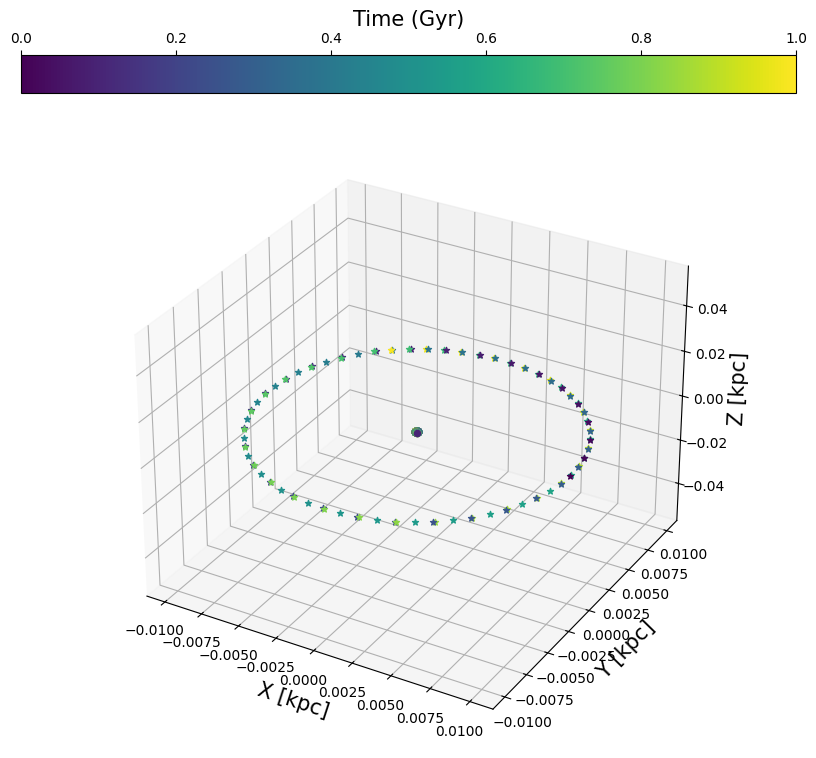

In [3]:
# Define the 
config = SimulationConfig(N_particles=2, 
                          return_snapshots=True, 
                          num_snapshots=100,
                          num_timesteps=1000, 
                          external_accelerations=(), softening=1e-10) #default values

params = SimulationParams(t_end = (1*u.Gyr).to(code_units.code_time).value, 
                          G=1) #default values

print(config)
print(params)

mass1 = (100*u.Msun).to(code_units.code_mass).value
mass2 = (1*u.Msun).to(code_units.code_mass).value
rp = (0.01*u.kpc).to(code_units.code_length).value
pos, vel, mass = ic_two_body(mass1, 
                             mass2, 
                             rp=rp, 
                             e=0., 
                             config=config, 
                             params=params)
mass = jnp.array([mass1, mass2])
initial_state = construct_initial_state(pos, vel)

snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))
# check the energy conservation, remove the last snapshot:

fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

# Normalize the times to the range [0, 1] for colormap
times = ((snapshots.times * code_units.code_time).to(u.Gyr)).value
# norm_times = (times - times.min()) / (snapshots.times.max() - snapshots.times.min())

# Generate colors using a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(times)
for i in range(0, len(snapshots.states), 1):
    sc = ax.scatter((snapshots.states[i, 0, 0, 0]*code_units.code_length).to(u.kpc).value, 
                    (snapshots.states[i, 0, 0, 1]*code_units.code_length).to(u.kpc).value, 
                    (snapshots.states[i, 0, 0, 2]*code_units.code_length).to(u.kpc).value, 
                    color=colors[i], )
    ax.scatter((snapshots.states[i, 1, 0, 0]*code_units.code_length).to(u.kpc).value, 
               (snapshots.states[i, 1, 0, 1]*code_units.code_length).to(u.kpc).value, 
               (snapshots.states[i, 1, 0, 2]*code_units.code_length).to(u.kpc).value, 
               color=colors[i],  marker='*', )
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
cbar = plt.colorbar(sc, location='top')
cbar.set_label('Time (Gyr)')



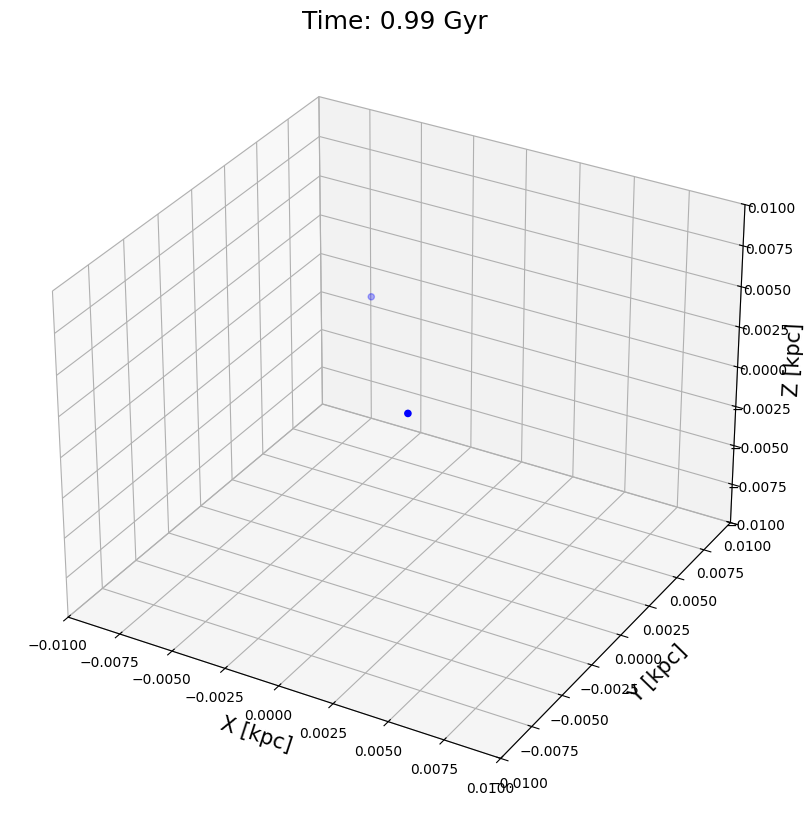

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter

def create_gif_from_snapshots(snapshots, filename=None):
    # Create a figure for plotting
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Initialize the scatter plot
    scatter1 = ax.scatter([], [], [], c='b')
    scatter2 = ax.scatter([], [], [], c='r', marker='*')

    def init():
        ax.set_xlabel('X [kpc]')
        ax.set_ylabel('Y [kpc]')
        ax.set_zlabel('Z [kpc]')
        return scatter1, scatter2

    def update(frame):
        ax.clear()
        ax.set_xlabel('X [kpc]')
        ax.set_ylabel('Y [kpc]')
        ax.set_zlabel('Z [kpc]')
        ax.set_xlim(-(rp*code_units.code_length).to(u.kpc).value, (rp*code_units.code_length).to(u.kpc).value)
        ax.set_ylim(-(rp*code_units.code_length).to(u.kpc).value, (rp*code_units.code_length).to(u.kpc).value)
        ax.set_zlim(-(rp*code_units.code_length).to(u.kpc).value, (rp*code_units.code_length).to(u.kpc).value)
        ax.set_title(f'Time: {(snapshots.times[frame]*code_units.code_time).to(u.Gyr).value:.2f} Gyr')
        scatter1 = ax.scatter((snapshots.states[frame, :, 0, 0]*code_units.code_length).to(u.kpc).value, 
                              (snapshots.states[frame, :, 0, 1]*code_units.code_length).to(u.kpc).value, 
                              (snapshots.states[frame, :, 0, 2]*code_units.code_length).to(u.kpc).value, c='b')
        return scatter1, scatter2

    # Create the animation
    anim = FuncAnimation(fig, update, frames=range(0, len(snapshots.states), 1), init_func=init, blit=False)

    # Save the animation as a GIF
    anim.save(filename, writer=PillowWriter(fps=10))

# Example usage
# Assuming snapshots is available
create_gif_from_snapshots(snapshots, filename='./visualization/gif/simulation_2body.gif')

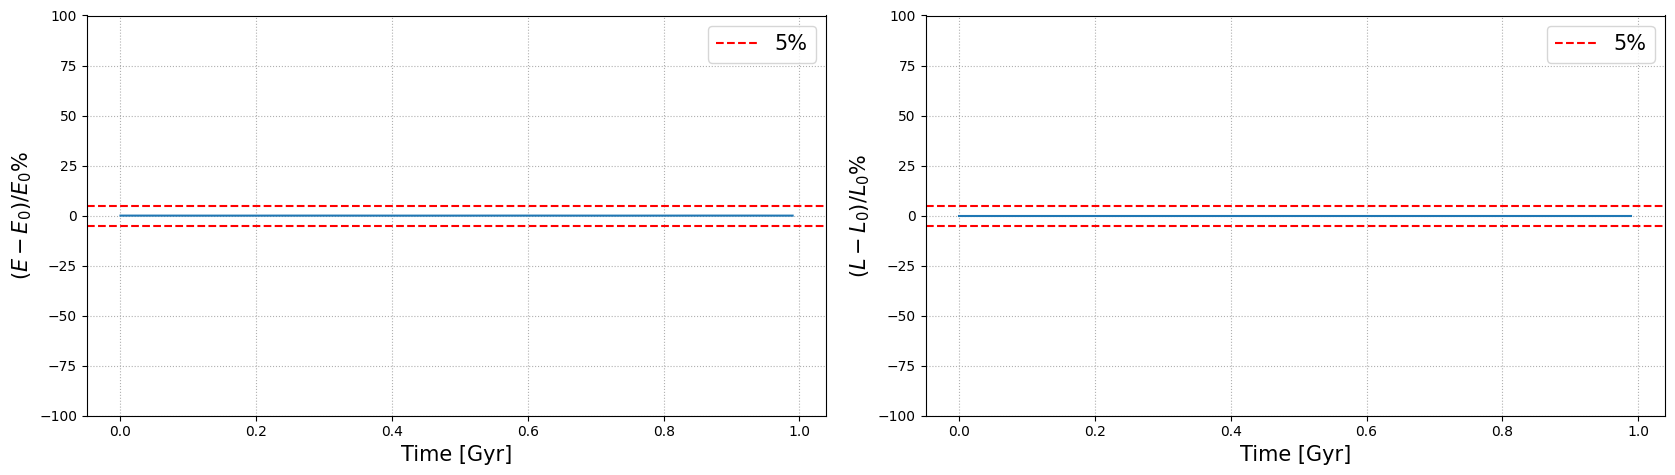

In [5]:
energy_angular_momentum_plot(snapshots, code_units, filename='./visualization/image/E_L_2body.pdf')